# Ghostnet for Hyperspectral Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.model_selection
from torch.nn import init
from torch.backends import cudnn
from operator import truediv
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from timm.layers import weight_init, DropPath
from timm.models.registry import register_model
import random
import time
import math
from thop import profile
from torchsummary import summary
device = torch.device('cuda:{}'.format(0))
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
cudnn.deterministic = True

# 1. Load data

## 1.1 Load img and gt as numpy.ndarray

In [2]:
datasets = {
        'PaviaU': {
            'img': 'PaviaU.mat',      #paviaU
            'gt': 'PaviaU_gt.mat'     #paviaU_gt
            },
        'houston2013':{
            'img': 'houston2013.mat', # houston2013
            'gt': 'DFC2013_gt.mat'# DFC2013_gt
        },
        'salinas':{
            'img': 'Salinas.mat', # salinas
            'gt': 'Salinas_gt.mat'# salinas_gt
        },
        'WHHC':{
            'img': 'hanchuan_half.mat', # hanchuan_half
            'gt': 'hanchuan_half_gt.mat'# half_new
        } ,
        'Dioni':{
            'img': 'Dioni.mat', # ori_data
            'gt': 'Dioni_gt_out68.mat'# map
        } 
}
dataset_name='Dioni'
dataset=datasets[dataset_name]
folder = './Datasets/'
img = io.loadmat(folder+dataset['img'])['ori_data']   

img= (img - np.min(img))/(np.max(img)-np.min(img))  
print(type(img),img.shape)
gt = io.loadmat(folder + dataset['gt'])['map']

<class 'numpy.ndarray'> (250, 1376, 176)


## 1.2 Visualization

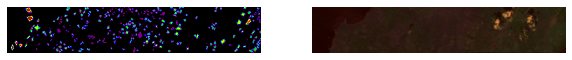

In [3]:
N_CLASSES = max(np.unique(gt))
N_BANDS = img.shape[-1]      
fig=plt.figure(num=1,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gt,cmap='nipy_spectral')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img[:,:,(10, 50, 100)]) 
# plt.imshow(img[:,:,(10, 20, 30)]) 
plt.axis('off')
plt.show()

## 1.3 Training set ,validation set and test set split

In [4]:
indices = np.nonzero(gt)
X = list(zip(*indices))
y = gt[indices] 
train_gt = np.zeros_like(gt)
test_gt = np.zeros_like(gt)
val_gt = np.zeros_like(gt)
print('train_gt: ',type(train_gt),train_gt.shape)

train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=0.03, random_state=0,stratify=y)

val_size = len(train_indices)
val_indices = test_indices[-val_size:]
test_indices = test_indices[:-val_size]

train_size = len(train_indices)
train_indices = list(zip(*train_indices))
val_indices = list(zip(*val_indices))
test_indices = list(zip(*test_indices))

train_gt[train_indices] = gt[train_indices]
val_gt[val_indices] = gt[val_indices]
test_gt[test_indices] = gt[test_indices]

# GHOSTNET&LS2CM Training set for hous2013
# train_gt = io.loadmat(folder+'TR_hous2013_5.mat')['Tr1'] 
# val_gt = io.loadmat(folder+'TV_hous2013_5.mat')['Tv1'] 
# test_gt = io.loadmat(folder+'TE_hous2013_5.mat')['Te_new1'] 


train_gt:  <class 'numpy.ndarray'> (250, 1376)


D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

## 1.4 Define dataloader

In [5]:
class HSIdata(torch.utils.data.Dataset):
    def __init__(self,data,gt):
        super(HSIdata, self).__init__()
        self.data = data   
        self.label = gt-1
        self.patch_size = 11
        self.data_all_offset = np.zeros((data.shape[0] + self.patch_size - 1, self.data.shape[1] + self.patch_size - 1, self.data.shape[2]))
        self.start = int((self.patch_size - 1) / 2)
        self.data_all_offset[self.start:data.shape[0] + self.start, self.start:data.shape[1] + self.start, :] = self.data[:, :, :]
        x_pos, y_pos = np.nonzero(gt)
    
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        self.labels = [self.label[x,y] for x,y in self.indices]
        
#         np.random.shuffle(self.indices)
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data_all_offset[x:x+self.patch_size, y:y+self.patch_size]
        label = self.label[x, y]
        data = np.asarray(data.transpose((2, 0, 1)), dtype='float32')
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
#         print(type(data[6,6,1]),data.shape)
#         print(label)
        return data, label,x,y

train_dataset = HSIdata(img, train_gt)
train_loader = torch.utils.data.DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=True)

val_dataset = HSIdata(img, val_gt)
val_loader = torch.utils.data.DataLoader(val_dataset,
                               batch_size=32,
                               shuffle=True)

test_dataset = HSIdata(img, test_gt)
test_loader = torch.utils.data.DataLoader(test_dataset,
                               batch_size=256,
                               shuffle=True)

all_gt_dataset = HSIdata(img,gt)
all_loader = torch.utils.data.DataLoader(all_gt_dataset,
                               batch_size=256,
                               shuffle=True)


# 2. Define Network structure 

In [6]:
class SELayer(nn.Module):

    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        out = channel // reduction
        if out == 0:
            out = 1
        self.fc = nn.Sequential(
            nn.Linear(channel, out),
            nn.ReLU(inplace=True),
            nn.Linear(out, channel),
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y=self.avg_pool(x).view(b,c)
        y=self.fc(y).view(b,c,1,1)
        return x*y.expand_as(x)

    
def depthwise_conv(inp, oup, kernel_size=3, stride=1, relu=False):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size, stride, kernel_size//2, groups=inp, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True) if relu else nn.Sequential(),
    )

class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]    
    

class GhostBottleneck(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se):
        super(GhostBottleneck, self).__init__()
        assert stride in [1, 2]

        self.conv = nn.Sequential(
            # pw
            GhostModule(inp, hidden_dim, kernel_size=1, relu=True),
            # dw
            depthwise_conv(hidden_dim, hidden_dim, kernel_size, stride, relu=False) if stride==2 else nn.Sequential(),
            # Squeeze-and-Excite
            SELayer(hidden_dim) if use_se else nn.Sequential(),
            # pw-linear
            GhostModule(hidden_dim, oup, kernel_size=1, relu=False),
        )

        if stride == 1 and inp == oup:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                depthwise_conv(inp, inp, kernel_size, stride, relu=False),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)

    
    
    
class BaseNet(nn.Module):

    def __init__(self, input_channels, n_classes, dropout=True):
        super(BaseNet, self).__init__()
        
        self.stem = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.use_dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.2)
            
        self.BottleNeck1 = GhostBottleneck(16, 16, 16, 1, 1, True)
        self.BottleNeck2 = GhostBottleneck(16, 48, 24, 3, 1, True)
        self.BottleNeck3 = GhostBottleneck(24, 72, 24, 1, 1, True)
        
        self.conv5 = nn.Conv2d(24, 72, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(72)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(72, 216)
        self.bn3 = nn.BatchNorm1d(216)
        self.fc2 = nn.Linear(216, n_classes)


    def forward(self, x):

        x1 = self.stem(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        if self.use_dropout:
            x1 = self.dropout(x1)

        x2 = self.BottleNeck1(x1)
        x2 = self.BottleNeck2(x2)
        x2 = self.BottleNeck3(x2)
        
        x3 = self.conv5(x2)
        x3 = self.bn2(x3)
        x3 = self.relu(x3)
        x3 = self.avgpool(x3)
        x3 = x3.view(x3.size(0), -1)
        x3 = self.fc1(x3)
        x3 = self.bn3(x3)
        if self.use_dropout:
            x1 = self.dropout(x1)        
        x3 = self.fc2(x3)
        
        return x3


# 3. Utils

In [7]:
def save_model(model, model_name, dataset_name, epoch):
    model_dir = './checkpoints/' + model_name + "/" + dataset_name + "/"
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    filename = str('w6') + "_epoch{}".format(epoch)
    print(filename)
    torch.save(model.state_dict(), model_dir + filename + '.pth')
    
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

# 4. Train define

In [8]:
def evaluate_accuracy(data_loader, net, loss):
#     val_loss = 0
    number = 0
    acc_sum = 0   
    test_num = 0
    with torch.no_grad():
        for iter_, (data, target,x,y) in enumerate(data_loader):
            val_loss = 0
            data, target = data.to(device), target.to(device)            
            net.eval()
            output = net(data)
            l = loss(output, target.long())
            acc_sum += (output.argmax(dim=1) == target.to(device)).float().sum().cpu().item()          
#             l = loss(output, target)
#             _, predicts = torch.max(output.data, 1)
            val_loss = val_loss + l
            number += len(target)
#             correct = correct + (predicts == target).sum()
            net.train()
            test_num += 1
        
    return [acc_sum / number, val_loss.cpu()]


def train(net, optimizer, critirian, data_loader, val_loader, epoch):
    loss_list = [1000]
    early_epoch = 0
    early_num = 20 
    early_stopping = 1
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    net.to(device)
    for e in range(1, epoch + 1):
        net.train()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)
        avg_loss = 0
        number = 0
        correct = 0
        for iter_, (data, target,x,y) in enumerate(data_loader):
            batch_count, train_l_sum = 0, 0
            data, target = data.to(device), target.to(device)            
            optimizer.zero_grad()
            output = net(data)
            #             print(target)
            loss = critirian(output, target)
            loss.backward()
            optimizer.step()
            _, predicts = torch.max(output.data, 1)
            avg_loss = avg_loss + loss.item()
            number += len(target)
            correct = correct + (predicts == target).sum()
            
        lr_adjust.step(epoch)
        valida_acc, valida_loss = evaluate_accuracy(val_loader, net, critirian)
        loss_list.append(valida_loss)
        avg_loss /= len(data_loader)     
        print('train--------')
#         print('Epoch:', e, 'loss:', avg_loss)
        acc = correct.item() / number
    
        train_loss_list.append(avg_loss)
        train_acc_list.append(acc)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

#         print('Epoch:', e, 'acc:', acc)
        print('epoch %d, train loss %.6f, train acc %.3f, valida  loss %.6f, valida acc %.3f'% (e + 1, avg_loss, acc, valida_loss, valida_acc))    
#         filename = str('LW') + "_epoch{}".format(e)
        PATH = "./LW_best_net.pt"
        global best_acc
        if valida_acc > best_acc:
            best_acc = valida_acc
            torch.save(net.state_dict(), PATH)
        if e == epoch:
            net.load_state_dict(torch.load(PATH))      
   
        if e % 100 == 0:
            save_model(net, 'basenet', dataset_name, e)



# 5.TRAIN & TEST

D:\anaconda3\envs\pytorch_envs\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train--------
epoch 2, train loss 1.677504, train acc 0.513, valida  loss 2.885075, valida acc 0.103
train--------
epoch 3, train loss 1.328295, train acc 0.620, valida  loss 1.696609, valida acc 0.383
train--------
epoch 4, train loss 0.979868, train acc 0.692, valida  loss 4.253877, valida acc 0.193
train--------
epoch 5, train loss 1.276784, train acc 0.635, valida  loss 4.133080, valida acc 0.327
train--------
epoch 6, train loss 0.949221, train acc 0.687, valida  loss 7.383183, valida acc 0.335
train--------
epoch 7, train loss 0.877387, train acc 0.717, valida  loss 6.859600, valida acc 0.233
train--------
epoch 8, train loss 0.698270, train acc 0.752, valida  loss 1.834731, valida acc 0.622
train--------
epoch 9, train loss 0.829077, train acc 0.710, valida  loss 3.936158, valida acc 0.335
train--------
epoch 10, train loss 0.756233, train acc 0.738, valida  loss 4.542662, valida acc 0.422
train--------
epoch 11, train loss 0.714469, train acc 0.748, valida  loss 3.788165, valid

train--------
epoch 83, train loss 0.189993, train acc 0.932, valida  loss 9.965461, valida acc 0.213
train--------
epoch 84, train loss 0.156822, train acc 0.943, valida  loss 3.247988, valida acc 0.622
train--------
epoch 85, train loss 0.192840, train acc 0.928, valida  loss 4.968733, valida acc 0.415
train--------
epoch 86, train loss 0.190567, train acc 0.928, valida  loss 9.544813, valida acc 0.198
train--------
epoch 87, train loss 0.133304, train acc 0.952, valida  loss 1.506945, valida acc 0.593
train--------
epoch 88, train loss 0.197330, train acc 0.923, valida  loss 0.629849, valida acc 0.742
train--------
epoch 89, train loss 0.213936, train acc 0.922, valida  loss 0.707781, valida acc 0.825
train--------
epoch 90, train loss 0.232082, train acc 0.925, valida  loss 1.930108, valida acc 0.650
train--------
epoch 91, train loss 0.199129, train acc 0.935, valida  loss 0.631268, valida acc 0.715
train--------
epoch 92, train loss 0.148043, train acc 0.938, valida  loss 2.76923

train--------
epoch 163, train loss 0.053605, train acc 0.987, valida  loss 0.760130, valida acc 0.852
train--------
epoch 164, train loss 0.172466, train acc 0.943, valida  loss 2.336499, valida acc 0.700
train--------
epoch 165, train loss 0.125991, train acc 0.952, valida  loss 4.034593, valida acc 0.485
train--------
epoch 166, train loss 0.101024, train acc 0.963, valida  loss 0.266350, valida acc 0.913
train--------
epoch 167, train loss 0.161823, train acc 0.953, valida  loss 16.648664, valida acc 0.142
train--------
epoch 168, train loss 0.193293, train acc 0.925, valida  loss 2.777552, valida acc 0.388
train--------
epoch 169, train loss 0.134318, train acc 0.948, valida  loss 4.171826, valida acc 0.508
train--------
epoch 170, train loss 0.098591, train acc 0.960, valida  loss 24.236670, valida acc 0.177
train--------
epoch 171, train loss 0.088067, train acc 0.972, valida  loss 0.407666, valida acc 0.828
train--------
epoch 172, train loss 0.070899, train acc 0.975, valida  

train--------
epoch 243, train loss 0.089450, train acc 0.975, valida  loss 0.734498, valida acc 0.743
train--------
epoch 244, train loss 0.133148, train acc 0.953, valida  loss 2.863677, valida acc 0.520
train--------
epoch 245, train loss 0.054069, train acc 0.978, valida  loss 2.336838, valida acc 0.588
train--------
epoch 246, train loss 0.041818, train acc 0.987, valida  loss 0.141639, valida acc 0.905
train--------
epoch 247, train loss 0.027686, train acc 0.993, valida  loss 0.359333, valida acc 0.917
train--------
epoch 248, train loss 0.011720, train acc 0.998, valida  loss 0.304926, valida acc 0.877
train--------
epoch 249, train loss 0.045638, train acc 0.983, valida  loss 0.997239, valida acc 0.810
train--------
epoch 250, train loss 0.054644, train acc 0.978, valida  loss 0.482741, valida acc 0.902
train--------
epoch 251, train loss 0.092970, train acc 0.972, valida  loss 1.775604, valida acc 0.688
train--------
epoch 252, train loss 0.055303, train acc 0.982, valida  lo

train--------
epoch 323, train loss 0.022201, train acc 0.993, valida  loss 0.524841, valida acc 0.745
train--------
epoch 324, train loss 0.059480, train acc 0.980, valida  loss 2.338567, valida acc 0.623
train--------
epoch 325, train loss 0.021373, train acc 0.992, valida  loss 0.101283, valida acc 0.860
train--------
epoch 326, train loss 0.022457, train acc 0.993, valida  loss 0.098771, valida acc 0.907
train--------
epoch 327, train loss 0.040004, train acc 0.985, valida  loss 2.362183, valida acc 0.790
train--------
epoch 328, train loss 0.008075, train acc 0.998, valida  loss 0.094011, valida acc 0.908
train--------
epoch 329, train loss 0.033880, train acc 0.985, valida  loss 23.954863, valida acc 0.180
train--------
epoch 330, train loss 0.042738, train acc 0.988, valida  loss 0.069536, valida acc 0.937
train--------
epoch 331, train loss 0.044574, train acc 0.987, valida  loss 0.503770, valida acc 0.688
train--------
epoch 332, train loss 0.036452, train acc 0.985, valida  l

train--------
epoch 403, train loss 0.007839, train acc 1.000, valida  loss 0.365827, valida acc 0.928
train--------
epoch 404, train loss 0.024346, train acc 0.992, valida  loss 0.397620, valida acc 0.933
train--------
epoch 405, train loss 0.008823, train acc 0.998, valida  loss 0.223431, valida acc 0.918
train--------
epoch 406, train loss 0.034848, train acc 0.987, valida  loss 0.778438, valida acc 0.793
train--------
epoch 407, train loss 0.022904, train acc 0.990, valida  loss 2.827701, valida acc 0.668
train--------
epoch 408, train loss 0.036955, train acc 0.992, valida  loss 2.894068, valida acc 0.680
train--------
epoch 409, train loss 0.031062, train acc 0.988, valida  loss 0.895327, valida acc 0.820
train--------
epoch 410, train loss 0.013686, train acc 0.995, valida  loss 0.342921, valida acc 0.925
train--------
epoch 411, train loss 0.010799, train acc 0.995, valida  loss 0.005764, valida acc 0.947
train--------
epoch 412, train loss 0.004546, train acc 0.998, valida  lo

train--------
epoch 483, train loss 0.015291, train acc 0.997, valida  loss 2.319715, valida acc 0.640
train--------
epoch 484, train loss 0.111464, train acc 0.960, valida  loss 1.933329, valida acc 0.727
train--------
epoch 485, train loss 0.066958, train acc 0.987, valida  loss 0.120203, valida acc 0.918
train--------
epoch 486, train loss 0.021855, train acc 0.995, valida  loss 0.062902, valida acc 0.782
train--------
epoch 487, train loss 0.033579, train acc 0.987, valida  loss 0.022174, valida acc 0.892
train--------
epoch 488, train loss 0.020207, train acc 0.995, valida  loss 0.460837, valida acc 0.890
train--------
epoch 489, train loss 0.015140, train acc 0.992, valida  loss 0.926324, valida acc 0.750
train--------
epoch 490, train loss 0.029908, train acc 0.993, valida  loss 0.026043, valida acc 0.907
train--------
epoch 491, train loss 0.007095, train acc 0.998, valida  loss 0.725982, valida acc 0.900
train--------
epoch 492, train loss 0.034569, train acc 0.987, valida  lo

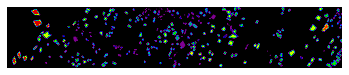

In [9]:
base_net=BaseNet(N_BANDS,N_CLASSES)
critirian=nn.CrossEntropyLoss().cuda()
lr=0.1
epochs=500
optimizer=torch.optim.SGD(base_net.parameters(),lr=lr,weight_decay=0.0001)
best_acc=0
kappa=0
cls_report=''
train_acc_list=[]
test_acc_list=[]
tic0 = time.perf_counter()
train(base_net,optimizer,critirian,train_loader,val_loader,epochs)
toc0 = time.perf_counter()
time_train = toc0 - tic0

tic = time.perf_counter()
number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())
toc = time.perf_counter()
time_test = toc - tic
predicts = predicts.tolist()

targets = targets.tolist()
acc = accuracy_score(predicts, targets)
test_acc_list.append(acc)
toc = time.perf_counter()
time_test = toc - tic
print('test-------')
# print('Epoch:', epoch)
print('test Acc:', acc)
kappa = cohen_kappa_score(predicts, targets)
print('Kappa', kappa)
con_matrics = confusion_matrix(predicts, targets)
each_acc, aa = AA_andEachClassAccuracy(con_matrics)
cls_report = classification_report(predicts, targets, digits=4)
#         print(con_matrics)
#         print(cls_report)
print('aa:',aa)
print('each acc:',each_acc)
print('train time:',time_train)
print('test time:',time_test)

X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()


# classification maps for all pixels

In [10]:
# y_temp = np.ones_like(gt)
# all_dataset = HSIdata(img,y_temp)
# all_map_loader = torch.utils.data.DataLoader(all_dataset,
#                                batch_size=256,
#                                shuffle=True)
# number = 0
# correct = 0
# predicts = np.zeros((0))
# targets = np.zeros((0))
# indicesX = []
# indicesY = []
# tic_all = time.perf_counter()
# with torch.no_grad():
#     for iter_, (data, target,x,y) in enumerate(all_map_loader):
#         data, target = data.to(device), target.to(device)
#         base_net.eval()
#         output = base_net(data)
#         _, predict = torch.max(output.data, 1)
#         predict = predict.cpu().numpy()
#         target = target.cpu().numpy()
#         predicts = np.append(predicts, predict)
#         targets = np.append(targets, target)
#         indicesX.extend(x.cpu().numpy().tolist())
#         indicesY.extend(y.cpu().numpy().tolist())
# toc_all = time.perf_counter()
# t_all_time = toc_all - tic_all
# print('inference all map pixels time:', t_all_time)

# predicts = predicts.tolist()
# X = np.array(indicesX)
# Y = np.array(indicesY)
# test_img = gt
# predicts_cor = [i+1 for i in predicts]
# test_img[X[:], Y[:]] = np.array(predicts_cor)
# plt.imshow(test_img, cmap='nipy_spectral')
# plt.axis('off')
# # plt.title("epoch:{}".format(epoch))
# plt.show()
# io.savemat( dataset_name + '_ghost_all_classmap.mat', {"classes_map": test_img})


# model complexity

In [11]:
input_x = torch.randn(1, N_BANDS, 11, 11)
input_x = input_x.cuda()
macs, params = profile(base_net, inputs=(input_x, ))
print("macs:",macs,"params:",params)
summary(base_net, input_size=(N_BANDS,11,11))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.GhostModule'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.SELayer'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.GhostBottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for 

In [12]:
# io.savemat( dataset_name + '_classmap.mat', {"classes_map": test_img})

In [13]:
# io.savemat( dataset_name + '_ghost_all_classmap.mat', {"classes_map": test_img})